In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import numpy as np
import json
import scvi
from sklearn.metrics import mean_squared_error

In [ ]:
path = "/Users/lukar818/Documents/postdoc/MCAR/data/visiumtwo" # set to location of glioblastoma data

In [301]:
with open(os.path.join(os.getcwd(), "data", "predids.json")) as json_file:
    json_data = json.load(json_file)

In [302]:
adata_all = sc.read_10x_mtx(
    os.path.join(path, "filtered_feature_bc_matrix"),
    var_names="gene_symbols",
    gex_only=False
)

In [ ]:
json_data['glioblastoma'].keys()

dict_keys(['PCNA', 'VIM', 'KRT', 'PTPRC', 'PAX5', 'BCL2', 'CD19', 'FCGR3A', 'CD3E', 'PECAM1'])

## PCNA Glioblastoma example

In [ ]:
test_barcodes = np.array(json_data['visiumBC']['PCNA'])
mask_test = np.isin(adata_all.obs_names, test_barcodes)
mask_train = ~mask_test


In [409]:
train_idx = np.where(mask_train)[0]
test_idx  = np.where(mask_test)[0]

rna = adata_all[:, adata_all.var["feature_types"] == "Gene Expression"]
prot = adata_all[:, adata_all.var["feature_types"] == "Antibody Capture"]

adata_train = ad.AnnData(
    X=rna.X[train_idx],
    obs=rna.obs.iloc[train_idx].copy(),
    var=rna.var.copy()
)
adata_train.obsm["protein_expression"] = prot.X[train_idx]
adata_train.uns["protein_names"] = prot.var_names.tolist()
adata_train.obs['batch'] = 'train'

adata_test = ad.AnnData(
    X=rna.X[test_idx],
    obs=rna.obs.iloc[test_idx].copy(),
    var=rna.var.copy()
)
adata_test.obsm["protein_expression"] = prot.X[test_idx]
adata_test.uns["protein_names"] = prot.var_names.tolist()
adata_test.obs['batch'] = 'train'

In [ ]:
adata_train.X = adata_train.X.toarray() if hasattr(adata_train.X, "toarray") else adata_train.X

adata_train.obsm["protein_expression"] = (
    adata_train.obsm["protein_expression"].toarray()
    if hasattr(adata_train.obsm["protein_expression"], "toarray")
    else adata_train.obsm["protein_expression"]
)

In [411]:
adata_test.X = adata_test.X.toarray() if hasattr(adata_test.X, "toarray") else adata_test.X

# Convert protein counts to dense
adata_test.obsm["protein_expression"] = (
    adata_test.obsm["protein_expression"].toarray()
    if hasattr(adata_test.obsm["protein_expression"], "toarray")
    else adata_test.obsm["protein_expression"]
)

In [412]:
for ads in [adata_train, adata_test]:
    prot = ads.obsm["protein_expression"]

    # Convert sparse → dense if needed
    if hasattr(prot, "toarray"):
        prot = prot.toarray()

    # Divide by 100 and floor to integers
    prot = (prot / 100).astype(int)

    ads.obsm["protein_expression"] = prot

In [413]:
sc.pp.highly_variable_genes(
    adata_train,
    flavor="seurat_v3",
    n_top_genes=4000,
    subset=True
)

sc.pp.highly_variable_genes(
    adata_test,
    flavor="seurat_v3",
    n_top_genes=4000,
    subset=True
)

In [414]:
# --- 5. Setup totalVI on training data ---
scvi.model.TOTALVI.setup_anndata(
    adata_train,
    protein_expression_obsm_key="protein_expression"
)

scvi.model.TOTALVI.setup_anndata(
    adata_test,
    protein_expression_obsm_key="protein_expression"
)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/var/folders/rs/_rjl71n16bgcl_57zv22vzx00000gn/T/ipykernel_92941/2377334654.py:2: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(
/var/folders/rs/_rjl71n16bgcl_57zv22vzx00000gn/T/ipykernel_92941/2377334654.py:7: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(


In [415]:
model = scvi.model.TOTALVI(adata_train,
                           latent_distribution="normal",
                           n_layers_decoder=2)
model.train(max_epochs=400,
            accelerator='mps')

INFO     Computing empirical prior initialization for protein background.                                          


/Users/lukar818/.pyenv/versions/totalvi/lib/python3.13/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/lukar818/.pyenv/versions/totalvi/lib/python3.13/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/Users/lukar818/.pyenv/versions/totalvi/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader

Epoch 400/400: 100%|██████████| 400/400 [04:56<00:00,  1.33it/s, v_num=1, train_loss_step=3.76e+3, train_loss_epoch=3.64e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:56<00:00,  1.35it/s, v_num=1, train_loss_step=3.76e+3, train_loss_epoch=3.64e+3]


<Axes: xlabel='epoch'>

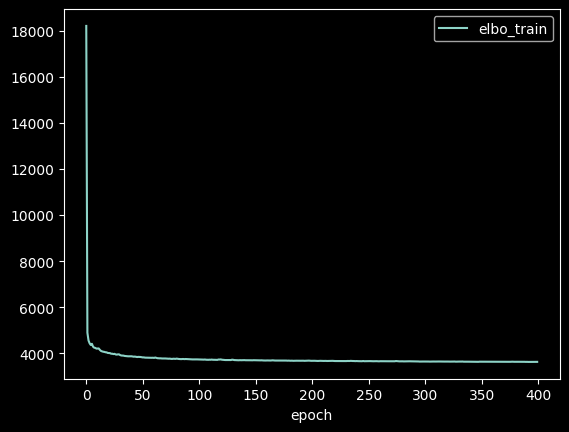

In [404]:
model.history["elbo_train"].plot()

In [418]:
true_proteins = adata_test.obsm["protein_expression"]  # (cells × proteins)

In [419]:
_, protein_pred = model.get_normalized_expression(
    adata_test,
    n_samples=50,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


## PCNA

In [286]:
from sklearn.metrics import mean_squared_error
rmse_per_protein = np.sqrt(
    np.mean((true_proteins - protein_pred) ** 2, axis=0)
)

for prot_name, rmse_val in zip(adata_test.uns["protein_names"], rmse_per_protein):
    if prot_name == "PCNA-1":print(f"{prot_name}: {rmse_val:.2f}")

PCNA-1: 181.93
